In [2]:
from temporora import *

In [3]:
import optuna
import lightgbm as lgb
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

Processing dataset: FD001


[I 2024-11-24 05:04:25,891] A new study created in memory with name: no-name-fa532fb9-5e71-483b-bc32-d800b0d6320a


Running Optuna optimization for dataset: FD001


C:\Users\Piyush\AppData\Local\Temp\ipykernel_30116\3839921517.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # Log-uniform distribution for C
C:\Users\Piyush\AppData\Local\Temp\ipykernel_30116\3839921517.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  epsilon = trial.suggest_uniform('epsilon', 0.01, 1.0)  # Uniform distribution for epsilon
[I 2024-11-24 05:04:27,960] Trial 0 finished with value: 0.051587842434388326 and parameters: {'C': 81.64668434590324, 'epsilon': 0.3470344537430975, 'kernel': 'poly'}. Best is trial 0 with value: 0.051587842434388326.
C:\Users\Piyush\AppData\Local\Temp\ipykernel_30116\3839921517.py:10: FutureWar

Best parameters for FD001: {'C': 0.03973445864001472, 'epsilon': 0.08688095281023363, 'kernel': 'linear'}
Dataset FD001 Metrics:
Test MSE: 225.3032, RMSE: 15.0101, R2: 0.8598


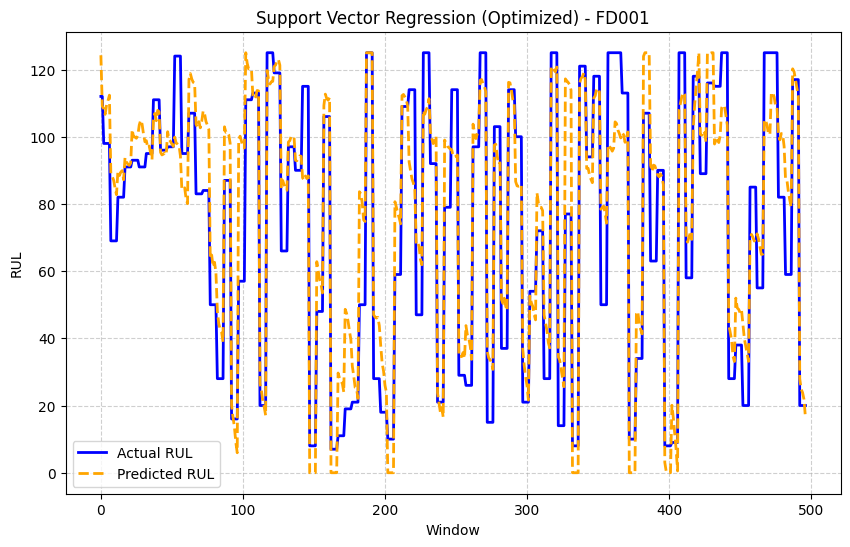

Processing dataset: FD002


[I 2024-11-24 05:37:47,838] A new study created in memory with name: no-name-79f025f4-59e6-43a9-9d61-89659d122b73


Running Optuna optimization for dataset: FD002


C:\Users\Piyush\AppData\Local\Temp\ipykernel_30116\3839921517.py:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 1e-2, 1e2)  # Log-uniform distribution for C
C:\Users\Piyush\AppData\Local\Temp\ipykernel_30116\3839921517.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  epsilon = trial.suggest_uniform('epsilon', 0.01, 1.0)  # Uniform distribution for epsilon


In [ ]:
import optuna
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

def objective(trial, x_train, y_train, x_valid, y_valid):
    """Objective function for Optuna optimization."""
    # Define the parameter search space
    C = trial.suggest_loguniform('C', 1e-2, 1e2)  # Log-uniform distribution for C
    epsilon = trial.suggest_uniform('epsilon', 0.01, 1.0)  # Uniform distribution for epsilon
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf'])  # Kernel choice

    # Define the SVR model with sampled parameters
    svr_model = SVR(C=C, epsilon=epsilon, kernel=kernel)

    # Train the model
    svr_model.fit(x_train, y_train)

    # Validate the model
    preds = svr_model.predict(x_valid)
    mse = mean_squared_error(y_valid, preds)

    return mse

# Assuming metrics is defined before this loop
for dataset in datasets:
    print(f"Processing dataset: {dataset}")
    args.sub_dataset = dataset  # Set current dataset

    # Load data using your custom get_dataloader function
    train_loader, valid_loader, test_loader, test_loader_last, \
        num_test_windows, train_visualize, engine_id = get_dataloader(
            dir_path=args.dataset_root,
            sub_dataset=args.sub_dataset,
            max_rul=args.max_rul,
            seq_length=args.sequence_len,
            batch_size=args.batch_size,
            use_exponential_smoothing=args.use_exponential_smoothing,
            smooth_rate=args.smooth_rate)

    # Prepare training and validation data
    x_train, y_train = [], []
    for i, (x, y) in enumerate(train_loader):
        x_train.append(x.view(-1, args.sequence_len * args.feature_num).numpy())
        y_train.append(y.numpy().ravel())  # Flatten y to 1D

    x_valid, y_valid = [], []
    for i, (x, y) in enumerate(valid_loader):
        x_valid.append(x.view(-1, args.sequence_len * args.feature_num).numpy())
        y_valid.append(y.numpy().ravel())  # Flatten y to 1D

    # Convert to numpy arrays
    x_train = np.vstack(x_train)
    y_train = np.concatenate(y_train, axis=0)
    x_valid = np.vstack(x_valid)
    y_valid = np.concatenate(y_valid, axis=0)

    # Optuna hyperparameter optimization
    print(f"Running Optuna optimization for dataset: {dataset}")
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective(trial, x_train, y_train, x_valid, y_valid), n_trials=20)

    # Best parameters
    print(f"Best parameters for {dataset}: {study.best_params}")
    best_params = study.best_params

    # Train final SVR model with best parameters
    svr_model = SVR(C=best_params['C'], epsilon=best_params['epsilon'], kernel=best_params['kernel'])
    svr_model.fit(x_train, y_train)

    # Test the model
    test_predictions, test_actuals = [], []
    for i, (x, y) in enumerate(test_loader):
        x = x.view(-1, args.sequence_len * args.feature_num).numpy()
        y = y.numpy().ravel()
        preds = svr_model.predict(x)

        test_predictions.extend(preds)
        test_actuals.extend(y)

    # Post-process predictions
    test_predictions = np.array(test_predictions)
    test_actuals = np.array(test_actuals)

    max_rul = test_actuals.max()
    test_predictions = np.clip(test_predictions, 0, max_rul)
    test_predictions = test_predictions * args.max_rul
    test_actuals = test_actuals * args.max_rul

    # Compute Metrics
    test_mse = mean_squared_error(test_actuals, test_predictions)
    test_rmse = np.sqrt(test_mse)
    test_r2 = r2_score(test_actuals, test_predictions)

    # Store metrics
    metrics[dataset] = {
        "Test MSE": test_mse,
        "Test RMSE": test_rmse,
        "Test R2": test_r2
    }

    # Print metrics for this dataset
    print(f"Dataset {dataset} Metrics:")
    print(f"Test MSE: {test_mse:.4f}, RMSE: {test_rmse:.4f}, R2: {test_r2:.4f}")

    # Inline Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(test_actuals, label='Actual RUL', color='blue', linewidth=2)
    plt.plot(test_predictions, label='Predicted RUL', color='orange', linestyle='--', linewidth=2)
    plt.xlabel('Window')
    plt.ylabel('RUL')
    plt.title(f'Support Vector Regression (Optimized) - {dataset}')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()  # Inline visualization during the loop
